# Task 1: Sentence Transformer Implementation

Load a pre-trained `distilbert-base-uncased` for generating sentence embeddings.
distilbert-base-uncased is roughly half the size of `bert-base-uncased`.
It uses 40% less memory and runs 60% faster while still maintain ~95% of BERT's performance.

In [1]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification


model_checkpoint = "distilbert-base-uncased"
num_labels = 2 # binary classification

# Load the pre-trained bert model finetuned for sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

c:\Users\baiji\anaconda3\envs\transformer\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\baiji\anaconda3\envs\transformer\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

Use **News_Category_Dataset_v3** for embedding visualization ([paper](https://arxiv.org/pdf/2209.11429), [dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset?resource=download)). Here I sample 300 news titles from "WELLNESS", "ENTERTAINMENT", "POLITICS" categories.

In [2]:
from utils import load_local_dataset_with_hf
import random

json_file_path = "News_Category_Dataset_v3.json"
categories = ["WELLNESS", "ENTERTAINMENT", "POLITICS"]
sentence_key = "headline"
label_key = "category"

dataset = load_local_dataset_with_hf(json_file_path, categories, 300, sentence_key, label_key)

# Print some random examples and their labels
for _ in range(5):
    i = random.randint(0, len(dataset[label_key]))
    print(dataset[label_key][i], "<-", dataset[sentence_key][i])

POLITICS <- No White House Treats For Halloween This Year
ENTERTAINMENT <- Song Premiere: J.D. McPherson, 'Bossy'
POLITICS <- CIA Director Mike Pompeo: Russia Will Try To Interfere With 2018 Elections
POLITICS <- Girl, 10, Reportedly Forced To Travel Out Of State For Abortion
WELLNESS <- Skinny Fat People: Why Being Skinny Doesn't Protect Us Against Diabetes and Death


Compute embeddings

In [3]:
# Tokenize the input
sample_tokens = tokenizer(dataset[sentence_key], padding=True, truncation=True, return_tensors="pt")

# Perform inference using the base model (exlucde classification layers) and get the embeddings
model.eval()
with torch.no_grad():
    outputs = model.base_model(**sample_tokens)
    hidden_states = outputs.last_hidden_state # Shape: [batch_size, seq_length, hidden_dim]

# Compute the mean embedding across tokens (seq_length) to get sentence embeddings [batch_size, hidden_dim]
attention_mask = sample_tokens["attention_mask"]
masked_hidden_states = hidden_states * attention_mask.unsqueeze(-1)  # Mask padding
mean_embedding = masked_hidden_states.sum(dim=1) / attention_mask.sum(dim=1).unsqueeze(-1)
print(mean_embedding)

tensor([[ 0.1574, -0.3061,  0.2150,  ...,  0.0027, -0.1097,  0.1348],
        [ 0.2149,  0.1034,  0.1736,  ...,  0.0974,  0.0164, -0.3290],
        [ 0.1881,  0.1665, -0.2126,  ..., -0.0929,  0.3183, -0.0194],
        ...,
        [-0.0509, -0.0506, -0.2573,  ..., -0.3768,  0.0319, -0.1008],
        [ 0.0076, -0.1769, -0.1465,  ..., -0.0815,  0.0934,  0.1344],
        [-0.2896, -0.4729,  0.1063,  ...,  0.0321,  0.0198,  0.1085]])


Reduce the embedding dimension to 2 and visualize embedding space. We can see that the sentence embedding roughly fall into 3 clusters, which represent the three categories we sampled from the dataset. This shows that the transformer can capture the meaning of the news titles and embed them into a high dimensional semantic space.

<Axes: >

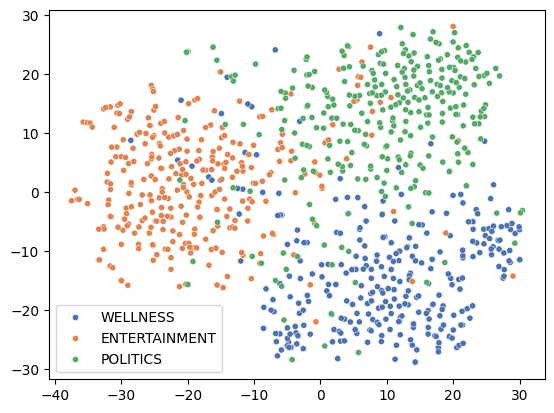

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce embedding dimensionality using t-SNE for visualization
viz_embeddings = TSNE(n_components=2).fit_transform(mean_embedding)

# Plot
sns.scatterplot(x=viz_embeddings[:, 0], y=viz_embeddings[:, 1], hue=dataset[label_key], palette="deep", s=20)

To get embeddings, I only need to mask and averge the last hidden states. Although classification embeddings (`last_hidden_state[:, 0, :]`) are included in the cluster analysis, they can be removed because they are used for classification task.
If getting the embeddings is our only goal, there is no need to add architecture outside of the transformer backbone.

# Task 2: Multi-Task Learning Expansion

## Task A: Sentence Classification - Classify news titles into three categories: Politics, Entertainment, and Wellness.

I will use a custom bert model that builds upon the pretrained bert model. I took the base_model from `distilbert-base-uncased` and added two classification layers on top with activation and dropout layers in between. Please see `model.py` for details.

Load dataset

In [1]:
from utils import load_local_dataset_with_hf


json_file_path = "News_Category_Dataset_v3.json"

# This is a multiclass classification task with 3 classes
categories = ["WELLNESS", "ENTERTAINMENT", "POLITICS"]

# Here I choose a small target sample size for demonstration
# Feel free to change it (the dominant label--POLITICS has 35,000 samples so don't exceed 35,000 * 3)
target_sample_size = 18000 * 3

sentence_key = "headline"
label_key = "category"

# Load data from json to hugging face Dataset
dataset = load_local_dataset_with_hf(json_file_path, categories, target_sample_size, sentence_key, label_key)


Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/209527 [00:00<?, ? examples/s]

Check sample size in each label

In [2]:
from collections import Counter


# Check the label distribution
count = Counter(dataset[label_key])
sample_size = max(count.values())
print(count)

Counter({'POLITICS': 18000, 'WELLNESS': 17945, 'ENTERTAINMENT': 17362})


Augment labels with fewer count to match the dominant label (especially when you use large sample size suchas 35000 * 3). I'll use back-translation for sentence augmentation. Please see details in `data_augmentation.py`. Let's see a small sample of augmented sentences first.

In [3]:
from data_augmentation import TranslationAugmentor


# Show an example of back translation
augmentor = TranslationAugmentor()
sample = dataset.shuffle(seed=1).select(range(3))[sentence_key]
augmented = augmentor.demo(sample, max_workers=0)
for a, b in zip(sample, augmented):
    print(f"original: {a}\naugmented: {b}\n")

c:\Users\baiji\anaconda3\envs\transformer\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\baiji\anaconda3\envs\transformer\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

Translating en → fr:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

Translating fr → en:   0%|          | 0.00/1.00 [00:00<?, ?batch/s]

original: Chris Christie Takes Bold Stand In Defense Of Donald Trump
augmented: Chris Christie defends Donald Trump

original: Some People Call It 'The Best Anti-Smoking Ad Ever.' After Watching, I Might Be One Of Them.
augmented: Some people call it 'the best anti-smoking advertising ever.' After watching, I could be one of them.

original: Few Lawmakers Seem Concerned With The Legal Justification For Attacking Syria
augmented: Few legislators seem concerned about the legal justification for the attack on Syria



Execute data augmentation and saves augmented dataset (THIS MAY TAKE A WHILE depending on the target sample size you chose)

In [4]:
# Execute augmentation 
augmented_dataset = augmentor.augment_dataset(dataset, sentence_key, label_key)

# Save the augmented dataset to local disk
augmented_dataset_path = "augmented_dataset"
augmented_dataset.save_to_disk(augmented_dataset_path)

Augmenting Labels:   0%|          | 0/3 [00:00<?, ?it/s]

Translating en → fr:   0%|          | 0.00/2.00 [00:00<?, ?batch/s]

Translating fr → en:   0%|          | 0.00/2.00 [00:00<?, ?batch/s]

Translating en → fr:   0%|          | 0.00/20.0 [00:00<?, ?batch/s]

Translating fr → en:   0%|          | 0.00/20.0 [00:00<?, ?batch/s]

Saving the dataset (0/1 shards):   0%|          | 0/54000 [00:00<?, ? examples/s]

Load the augmented data and do train/test/validation split

In [9]:
from datasets import load_from_disk


augmented_dataset = load_from_disk(augmented_dataset_path)

# Set label column
augmented_dataset = augmented_dataset.class_encode_column(label_key)

# Split the dataset into train/test/valid 8:1:1
split_dataset = augmented_dataset.train_test_split(
    test_size=0.2,
    seed=3,
    stratify_by_column=label_key
)

valid_dataset = split_dataset["test"].train_test_split(
    test_size=0.5,
    seed=3,
    stratify_by_column=label_key
)

final_dataset = {
    "train": split_dataset["train"],
    "validation": valid_dataset["train"],
    "test": valid_dataset["test"]
}

final_dataset

Casting to class labels:   0%|          | 0/54000 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['category', 'headline'],
     num_rows: 43200
 }),
 'validation': Dataset({
     features: ['category', 'headline'],
     num_rows: 5400
 }),
 'test': Dataset({
     features: ['category', 'headline'],
     num_rows: 5400
 })}

Train the model using the custom bert class I built (uses custom train loop). Please see `model.py` for detailed explanations.

In [11]:
from model import CustomBertModel


# Still use distilbert-base-uncased for space and time efficiency
model_checkpoint = "distilbert-base-uncased"

# Initialize the custom model for multi-class classification with 3 classes
model = CustomBertModel(model_checkpoint, num_labels=3)

sentence_key = "headline"
label_key = "category"

# Train the model
train_loss_history, val_accuracy_history, val_f1_history = model.train_loop(
    train_dataset=final_dataset["train"],
    sentence_key=sentence_key,
    label_key=label_key,
    eval_dataset=final_dataset["validation"],
    learning_rate=2e-5, # Typical learning rate for fine-tuning is between 1e-5 to 5e-5
    batch_size=16, # Samller batch size for memory efficiency
    num_epochs=5, # This can be increased for better training result
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/43200 [00:00<?, ? examples/s]

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Epoch 1/5: 100%|██████████| 2700/2700 [03:56<00:00, 11.44it/s, loss=0.1948]


Train Loss: 0.4566
Eval Accuracy: 0.8869, Eval F1 (macro): 0.8867


Epoch 2/5: 100%|██████████| 2700/2700 [03:46<00:00, 11.93it/s, loss=0.2207]


Train Loss: 0.3047
Eval Accuracy: 0.8956, Eval F1 (macro): 0.8953


Epoch 3/5: 100%|██████████| 2700/2700 [03:53<00:00, 11.54it/s, loss=0.3625]


Train Loss: 0.2891
Eval Accuracy: 0.9007, Eval F1 (macro): 0.9007


Epoch 4/5: 100%|██████████| 2700/2700 [03:48<00:00, 11.82it/s, loss=0.4341]


Train Loss: 0.2784
Eval Accuracy: 0.9013, Eval F1 (macro): 0.9011


Epoch 5/5: 100%|██████████| 2700/2700 [03:48<00:00, 11.84it/s, loss=0.1219]


Train Loss: 0.2717
Eval Accuracy: 0.9044, Eval F1 (macro): 0.9044
Training complete.


Plot training loss and eval metrics by epoch

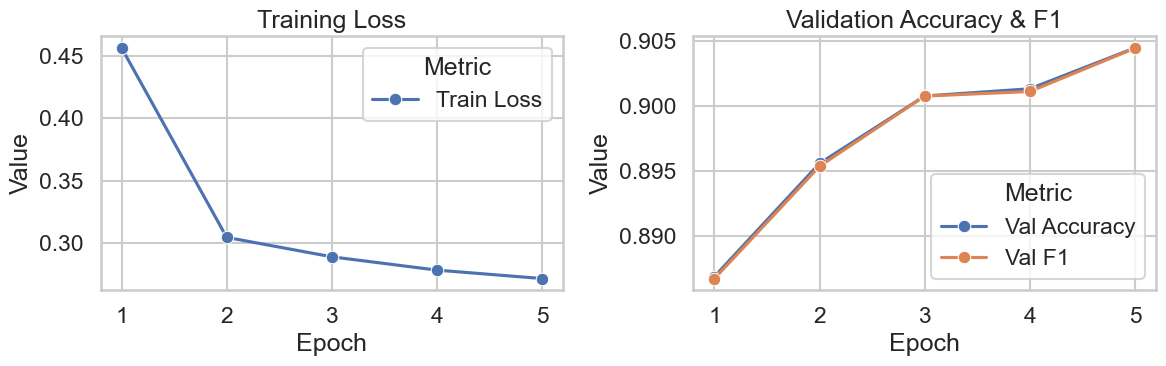

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Create a DataFrame for better plotting
data = pd.DataFrame({
    "Epoch": list(range(1, len(train_loss_history) + 1)) * 3,
    "Value": train_loss_history + val_accuracy_history + val_f1_history,
    "Metric": (["Train Loss"] * len(train_loss_history)) +
              (["Val Accuracy"] * len(val_accuracy_history)) +
              (["Val F1"] * len(val_f1_history))
})

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(12, 4))

# Left subplot: Training Loss
plt.subplot(1, 2, 1)
sns.lineplot(x="Epoch", y="Value", hue="Metric",
             data=data[data["Metric"] == "Train Loss"], marker="o")
plt.title("Training Loss")

# Right subplot: Val Accuracy & F1
plt.subplot(1, 2, 2)
sns.lineplot(x="Epoch", y="Value", hue="Metric",
             data=data[data["Metric"] != "Train Loss"], marker="o")
plt.title("Validation Accuracy & F1")

plt.tight_layout()
plt.show()

Show some sample predictions in the test set

In [13]:
# Take a small sample of test sentences for showcase
test_sentences = final_dataset["test"].shuffle(seed=3).select(range(5))
ground_truth = test_sentences[label_key]

# Make predictions
predictions = model.predict(test_sentences[sentence_key])

# Print the results
label_class = final_dataset["test"].features[label_key]
for text, pred, true in zip(test_sentences[sentence_key], predictions, ground_truth):
    print(text)
    print(f"Pred: {label_class.int2str(pred)}. True: {label_class.int2str(true)}\n")

5 Soul-Thoughts for a Radiant Life
Pred: WELLNESS. True: WELLNESS

REPORT: NSA's Intercepted Data Mostly Not From Intended Targets
Pred: POLITICS. True: POLITICS

Americans Really Don't Want Trump To Sabotage Obamacare, Poll Finds
Pred: POLITICS. True: POLITICS

WATCH LIVE: 'Game Of Thrones' After Show
Pred: ENTERTAINMENT. True: ENTERTAINMENT

Selena Gomez Doesn't Think She'll Ever 'Overcome' Depression And Anxiety
Pred: ENTERTAINMENT. True: ENTERTAINMENT



I didn't change the structure of the base model. Two classication layers are added on the top of the base model for the classification task. I froze the weights of the base model and only trained classification layers for faster convergence. Given enough data and computing resources, you can fine-tune the entire model for better performance.

**Alternative**: Finetuning can also be done conveniently by the `Trainer` API from the `transformers` library. It provides a well-optimized default configuration, including built-in support for optimizers, GPU acceleration, and hyperparameter tuning. Additionally, Trainer supports various distributed training strategies, such as FSDP-XLA, SageMaker MP/DP, DataParallel, and IPEX, allowing efficient scaling across different hardware environments.

## Task B: Sentiment Analysis

I will fine tune a pretrained bert model using the Trainer API on the SST-2 (Stanford Sentiment Treebank) dataset.

In [18]:
import random

from datasets import load_dataset
from evaluate import load


# Load the SST-2 dataset and the corresponding metric
dataset = load_dataset("glue", "sst2")

# Define the sentence and label keys
sentence_key = "sentence"
label_key = "label"

# Show random samples
label_class = dataset["train"].features[label_key]
for _ in range(5):
    i = random.randint(0, len(dataset["train"][label_key]))
    label = label_class.int2str(dataset["train"][label_key][i])
    sentence = dataset["train"][sentence_key][i]
    print(label, "<-", sentence)


positive <- this film for its harsh objectivity and refusal to seek our tears , our sympathies 
positive <- `` spider-man '' certainly delivers the goods 
positive <- does have its charms . 
positive <- any awards 
positive <- amazing slapstick 


Load the pretrained model and configure training parameters 

In [19]:
import numpy as np
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer


# Use distilbert-base-uncased for space and time efficiency
model_checkpoint = "distilbert-base-uncased"

# Binary classification: positive or negative
num_labels = 2 

# Load the pre-trained bert model finetuned for sequence classification head
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Freeze the base model's weights
for param in model.base_model.parameters():
    param.requires_grad = False

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

# Use the accuracy as the metric
metric_name = "accuracy"
metric = load('glue', 'sst2')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Convert probability to predicted class
    predictions = np.argmax(predictions, axis=1)
    
    return metric.compute(predictions=predictions, references=labels)

# Small batch size for memory efficiency
batch_size = 16

# Specify the training arguments
args = TrainingArguments(
    f"{model_checkpoint}-finetuned-sst2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5, # standard fine tune lr for transformers
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01, # L2 regularization
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\baiji\anaconda3\envs\transformer\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Tokenize the data before hand to speed up training

In [20]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples[sentence_key], padding=True, truncation=True)
encoded_dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Run training

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\baiji\AppData\Local\Temp\ipykernel_25276\3525685056.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.188800,0.290642,0.899083
2,0.138200,0.423430,0.891055
3,0.086500,0.430148,0.900229
4,0.066100,0.446744,0.908257
5,0.046700,0.549581,0.904817


TrainOutput(global_step=21050, training_loss=0.11194871036004, metrics={'train_runtime': 3546.9809, 'train_samples_per_second': 94.938, 'train_steps_per_second': 5.935, 'total_flos': 5626008140971860.0, 'train_loss': 0.11194871036004, 'epoch': 5.0})

In [22]:
trainer.evaluate()

{'eval_loss': 0.4467436969280243,
 'eval_accuracy': 0.908256880733945,
 'eval_runtime': 2.4604,
 'eval_samples_per_second': 354.413,
 'eval_steps_per_second': 22.354,
 'epoch': 5.0}

# Task 3: Training Considerations

1. If the entire network should be frozen.
    - **No**. If the entire network is frozen, there will be no weight updates, which means no fine-tuning can occur. In this case, the model can only perform the classification tasks it was originally trained for, without adapting to new tasks or domains.
2. If only the transformer backbone should be frozen.
    - **Optional**. The transformer backbone is responsible for generating meaningful embeddings (as demonstrated in the scatter plot in Task 1). Even if the specific task changes, the fundamental meanings of sentences remain relatively stable. Therefore, freezing the backbone while training only the classification layer can be effective, especially when data and computational resources are limited. This approach is often sufficient for achieving decent results in a new task.
    - However, training the entire network, including the backbone, can yield better performance, as different tasks may require nuanced adjustments in sentence embeddings.
3. If only one of the task-specific heads (either for Task A or Task B) should be frozen.
    - **No**. Training task-specific heads is essential for adapting the base model to various tasks. Each head fine-tunes the model's output to better suit the particular requirements of Task A or Task B, enabling effective multi-task learning.
4. Transfer learning
    - In NLP, transfer learning is highly advantageous. Foundation models are pre-trained on massive datasets, capturing the meanings of a wide range of words and sentences, making them versatile across diverse NLP tasks.
    - In contrast, the vision domain poses unique challenges. For instance, a CNN trained on ImageNet may not transfer well to microscopic images of proteins due to differences in high-level features. However, transfer learning still offers value here. Lower convolutional layers, pre-trained on ImageNet, can accelerate training on new datasets by recognizing basic features (such as lines or edges) that are common across domains.
    - In summary, transfer learning is most beneficial when the current dataset shares some similarities with the pre-trained model's training data. It enables faster convergence and often improves performance on new tasks by leveraging prior knowledge.

# Task 4: Training Loop Implementation (BONUS)

Please see `model.py` used for Task 2A